## Import necessary modules and read in data

In [1]:
# necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats import multitest
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg


/Users/chitwood/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#read in data

grapevine_data = pd.read_csv('modeling_data.csv') # ring widths for modeling
trait_data = pd.read_csv('all_trait_data.csv') # vineyard trait data for correlation
phys_data = pd.read_csv('phys_data.csv') # physiological data from LICOR measurements
ring_data = pd.read_csv('ring_data.csv') # just ring data, for merging with physiological data

_________
__________
# OVERALL CONTENTS

1. MODEL RING WITH AS A FUNCTION OF RING NUMBER
2. CORRELATE EACH TRAIT FOR EACH YEAR (1995-1999) WITH EACH RING FEATURE AND MODEL VALUE
3. CALCULATE AND VISUALIZE THE PERCENT CONTRIBUTION OF ROOTSTOCK TO TRUNK RADIUS IN CHARDONNAY AND CABERNET SAUVIGNON
4. PH AND TRUNK RADIUS (cm)
5. PRUNING WEIGHT AND TOTAL TRUNK DIAMETER (cm)
6. YIELD DIVIDED BY PRUNING WEIGHT (RAVAZ INDEX) AND TRUNK RADIUS (cm)
7. REPEATED MEASURES CORRELATION ON PHYSIOLOGY TRAITS AND TRUNK RADIUS (cm)
________
_______

_____
# 1. MODEL RING WIDTH AS A FUNCTION OF RING NUMBER 

1. Model overall ring widths and by scion for all data
2. Model ring widths for each vine
3. Model ring widths for each rootstock for each scion
4. Retrieve model values for each vine and determine how they vary by scion and rootstock
5. "A" does not significantly vary by scion or rootstock
6. "B" varies strongly by scion compared to rootstock
7. "K" is significant for rootstock but not scion
8. Rename vine for model data and merge with trait data for correlation
_____

## Model overall ring widths and by scion for all data

/Users/chitwood/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/chitwood/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/chitwood/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


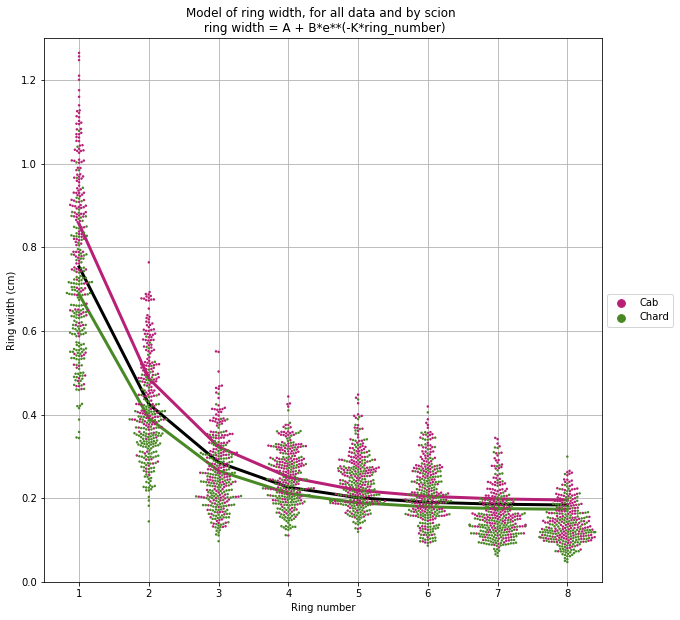

In [3]:
scion_pal = {"Chard":"#498925","Cab":"#b72076"}

# create negative exponential function 
def my_func(ring_num, A, B, K):
    form_width = A + B*np.exp(-K*ring_num)
    return form_width

# get parameter values and create model fit for all data
param_all, cov = curve_fit(my_func, grapevine_data["ring"], grapevine_data["width_cm"])
model_fit_all = my_func(grapevine_data["ring"], param_all[0], param_all[1], param_all[2])

# get parameter values and create model fit for Chardonnay
chard_data = grapevine_data[grapevine_data["scion"]=="Chard"]
param_chard, cov = curve_fit(my_func, chard_data["ring"], chard_data["width_cm"])
model_fit_chard = my_func(chard_data["ring"], param_chard[0], param_chard[1], param_all[2])

# get parameter values and create model fit for Cabernet sauvignon
cab_data = grapevine_data[grapevine_data["scion"]=="Cab"]
param_cab, cov = curve_fit(my_func, cab_data["ring"], cab_data["width_cm"])
model_fit_cab = my_func(cab_data["ring"], param_cab[0], param_cab[1], param_cab[2])

plt.figure(figsize=(10,10))
sns.swarmplot(data=grapevine_data, x="ring", y="width_cm", hue="scion", s=2.5, palette=scion_pal)
plt.plot(grapevine_data["ring"]-1, model_fit_all, c="k", lw=3)
plt.plot(chard_data["ring"]-1, model_fit_chard, c="#498925", lw=3)
plt.plot(cab_data["ring"]-1, model_fit_cab, c="#b72076", lw=3)
plt.title("Model of ring width, for all data and by scion \n ring width = A + B*e**(-K*ring_number)")
plt.xlabel('Ring number')
plt.ylabel('Ring width (cm)')
plt.ylim(0,1.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.savefig("FIGURE2A_SWARMPLOT.jpg")

## Model ring widths for each vine

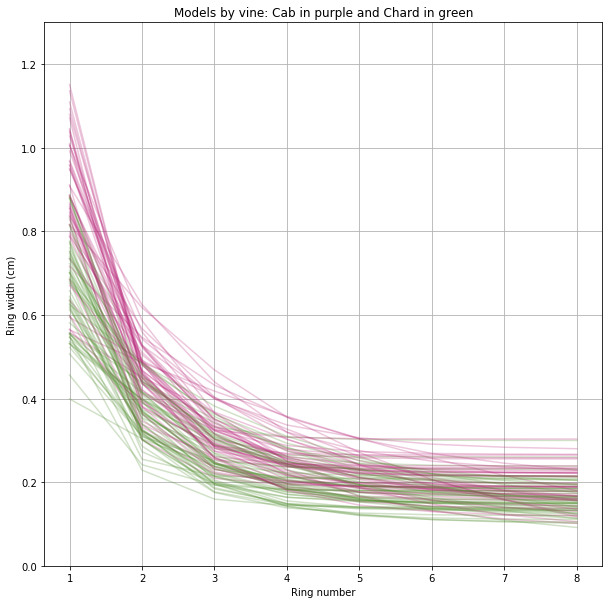

In [4]:
# mask out vines for which models can not be fit and outliers

mask_grapevine_data = grapevine_data[grapevine_data['vine'] != 'Chard_Kober 5BB_11_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_3_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_110 Richter_25_4']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_Ramsey_17_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_7_4'] #outlier
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_1103 Paulsen_23_1'] #outlier
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_8_2'] #outlier

A_list = []
B_list = []
K_list = []
scion_list = []
rootstock_list = []

vines = mask_grapevine_data["vine"].unique().tolist()

plt.figure(figsize=(10,10))

for vine in vines:
    
    sample_vine = grapevine_data[grapevine_data["vine"]==vine]

    param_vine, cov = curve_fit(my_func, sample_vine['ring'], sample_vine['width_cm'])
    model_fit_vine = my_func(sample_vine['ring'], param_vine[0], param_vine[1], param_vine[2])
    
    A_list.append(param_vine[0])
    B_list.append(param_vine[1])
    K_list.append(param_vine[2])
    scion_list.append(sample_vine["scion"].iloc[0])
    rootstock_list.append(sample_vine["rootstock"].iloc[0])
    
    if sample_vine["scion"].iloc[0]=="Cab":
        current_col = "#b72076"
        
    else:
        current_col = "#498925"
        
    
    plt.title("Models by vine: Cab in purple and Chard in green")
    plt.plot(sample_vine['ring'], model_fit_vine, c=current_col,alpha=0.25)
   
    plt.xlabel('Ring number')
    plt.ylabel('Ring width (cm)')
    
    plt.ylim(0,1.3)

plt.grid()

plt.savefig("FIGURE2B_SCIONS.jpg")

  

## Model ring widths for each rootstock for each scion

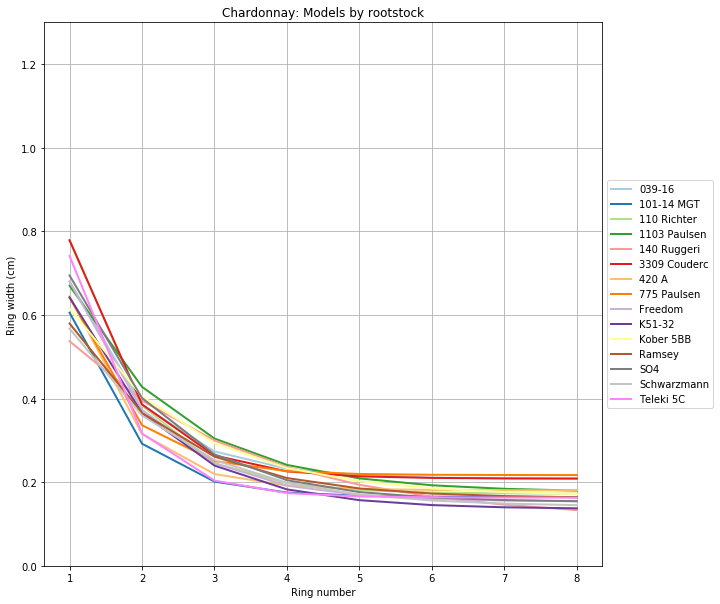

In [5]:
# Chardonnay: models by rootstock

rootstock_pal = {'039-16':"#a6cee3",'101-14 MGT':"#1f78b4",'110 Richter':"#b2df8a",'1103 Paulsen':"#33a02c",
                 '140 Ruggeri':"#fb9a99",'3309 Couderc':"#e31a1c",'420 A':"#fdbf6f",'775 Paulsen':"#ff7f00",
                 'Freedom':"#cab2d6",'K51-32':"#6a3d9a",'Kober 5BB':"#ffff99",'Ramsey':"#b15928",'SO4':"#7D7D7D",
                 'Schwarzmann':"#C4C4C4",'Teleki 5C':"#FF83FC"}
A_list = []
B_list = []
K_list = []
rootstock_list = []

chard_data = grapevine_data[grapevine_data["scion"]=="Chard"]
rootstocks = sorted(chard_data["rootstock"].unique().tolist())

plt.figure(figsize=(10,10))

for rootstock in rootstocks:
    
    sample_rootstock = chard_data[chard_data["rootstock"]==rootstock]

    param_rootstock, cov = curve_fit(my_func, sample_rootstock['ring'], sample_rootstock['width_cm'])
    model_fit_rootstock = my_func(sample_rootstock['ring'], param_rootstock[0], param_rootstock[1], param_rootstock[2])
    
    A_list.append(param_rootstock[0])
    B_list.append(param_rootstock[1])
    K_list.append(param_rootstock[2])
    rootstock_list.append(sample_vine["rootstock"].iloc[0])
    
    plt.title("Chardonnay: Models by rootstock")
    plt.plot(sample_rootstock['ring'], model_fit_rootstock, alpha=1,label=rootstock, c=rootstock_pal[rootstock], lw=2)
   
    plt.xlabel('Ring number')
    plt.ylabel('Ring width (cm)')
    plt.ylim(0,1.3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.savefig("FIGURE2C_CHARD_MODELS.jpg")
    

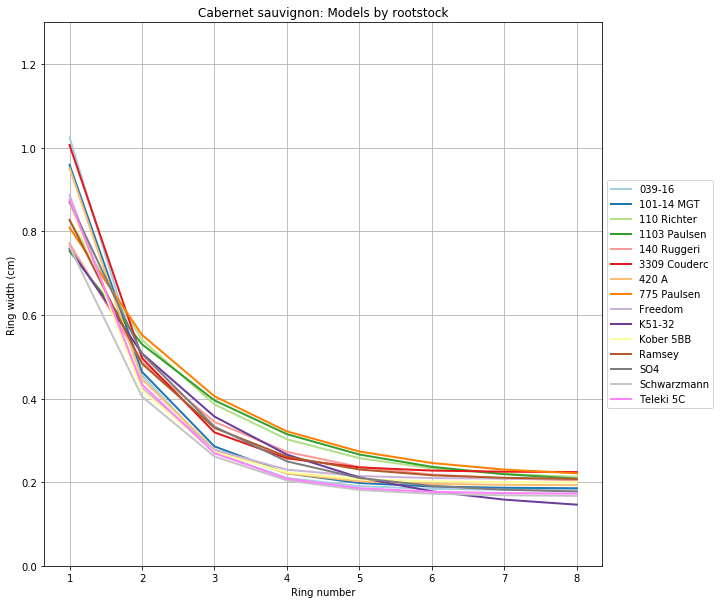

In [6]:
# Cabernet sauvignon: models by rootstock

A_list = []
B_list = []
K_list = []
rootstock_list = []


cab_data = grapevine_data[grapevine_data["scion"]=="Cab"]
cab_data = cab_data[cab_data["vine"]!='Cab_775 Paulsen_16_1']
cab_data = cab_data[cab_data["vine"]!="Cab_110 Richter_16_3"]

rootstocks = sorted(cab_data["rootstock"].unique().tolist())

plt.figure(figsize=(10,10))

for rootstock in rootstocks:
    
    sample_rootstock = cab_data[cab_data["rootstock"]==rootstock]

    param_rootstock, cov = curve_fit(my_func, sample_rootstock['ring'], sample_rootstock['width_cm'])
    model_fit_rootstock = my_func(sample_rootstock['ring'], param_rootstock[0], param_rootstock[1], param_rootstock[2])
    
    A_list.append(param_rootstock[0])
    B_list.append(param_rootstock[1])
    K_list.append(param_rootstock[2])
    rootstock_list.append(sample_vine["rootstock"].iloc[0])
    
    plt.title("Cabernet sauvignon: Models by rootstock")
    plt.plot(sample_rootstock['ring'], model_fit_rootstock, alpha=1,label=rootstock, c=rootstock_pal[rootstock], lw=2)
   
    plt.xlabel('Ring number')
    plt.ylabel('Ring width (cm)')
    plt.ylim(0,1.3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.savefig("FIGURE2D_CAB_MODELS.jpg")
    

## Retrieve model values for each vine and determine how they vary by scion and rootstock

In [7]:
# mask out vines for which models can not be fit

mask_grapevine_data = grapevine_data[grapevine_data['vine'] != 'Chard_Kober 5BB_11_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_3_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_110 Richter_25_4']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_Ramsey_17_1']
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_7_4'] #outlier
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Cab_1103 Paulsen_23_1'] #outlier
mask_grapevine_data = mask_grapevine_data[mask_grapevine_data['vine'] != 'Chard_775 Paulsen_8_2'] #outlier

rows = []

vines = mask_grapevine_data["vine"].unique().tolist()

for vine in vines:
    
    sample_vine = grapevine_data[grapevine_data["vine"]==vine]

    param_vine, cov = curve_fit(my_func, sample_vine['ring'], sample_vine['width_cm'])
    model_fit_vine = my_func(sample_vine['ring'], param_vine[0], param_vine[1], param_vine[2])
    
    vine_val = vine
    scion_val = sample_vine["scion"].iloc[0]
    rootstock_val = sample_vine["rootstock"].iloc[0]
    A_val = param_vine[0]
    B_val = param_vine[1]
    K_val = param_vine[2]

    rows.append([vine_val, scion_val, rootstock_val, A_val, B_val, K_val])
    
df = pd.DataFrame(rows, columns=["vine", "scion", "rootstock", "A", "B", "K"])    


## "A" does not significantly vary by scion or rootstock

In [8]:
 # A, translation along y axis, does not significantly vary

lm = ols("A~rootstock*scion", data=df).fit() # perform ANOVA
sm.stats.anova_lm(lm) # print out ANOVA results


,df,sum_sq,mean_sq,F,PR(>F)
rootstock,14.0,0.100470,0.007176,1.807978,0.052846
scion,1.0,0.007763,0.007763,1.955669,0.166099
rootstock:scion,14.0,0.047114,0.003365,0.847820,0.616334
Residual,75.0,0.297698,0.003969,NaN,NaN


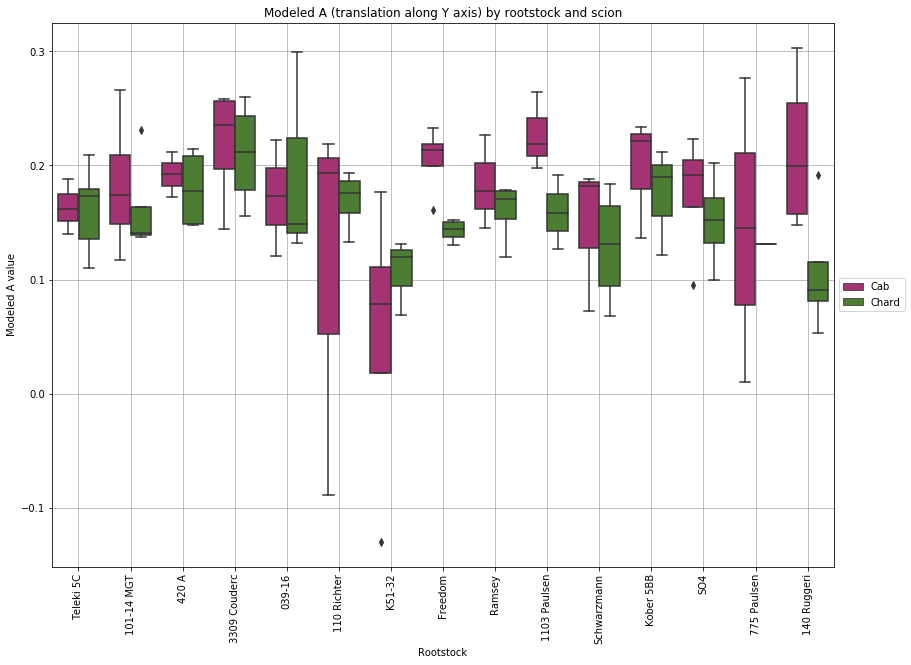

In [9]:
scion_pal = {"Chard": "#498925", "Cab": "#b72076"}

plt.figure(figsize=(14,10))
ax = sns.boxplot(data=df, x="rootstock", y="A", hue="scion", palette=scion_pal,
                    order=["Teleki 5C","101-14 MGT","420 A","3309 Couderc","039-16",
                           "110 Richter","K51-32","Freedom","Ramsey","1103 Paulsen",
                            "Schwarzmann","Kober 5BB", "SO4","775 Paulsen","140 Ruggeri"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid()
ax.set_axisbelow(True)
plt.xlabel("Rootstock")
plt.ylabel("Modeled A value")
plt.title("Modeled A (translation along Y axis) by rootstock and scion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("FIGURE2E_A.jpg")


## "B" varies strongly by scion compared to rootstock

In [10]:
# B, same asymptote and decay, but the initial value
# B varies strongly by scion and is barely significant by rootstock
# The increased width of Cabernet sauvignon is not overall width,
# but is mostly due to the width of the first rings

lm = ols("B~rootstock*scion", data=df).fit() # perform ANOVA
sm.stats.anova_lm(lm) # print out ANOVA results

,df,sum_sq,mean_sq,F,PR(>F)
rootstock,14.0,16.222138,1.158724,1.895083,0.040319
scion,1.0,10.822305,10.822305,17.699781,0.000071
rootstock:scion,14.0,8.876754,0.634054,1.036989,0.427624
Residual,75.0,45.857792,0.611437,NaN,NaN


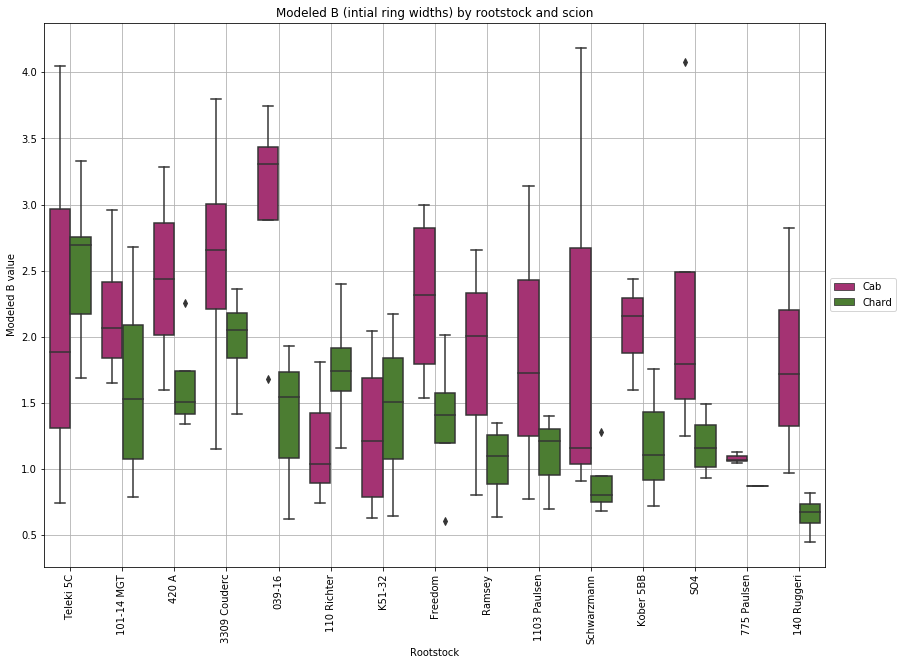

In [11]:
scion_pal = {"Chard": "#498925", "Cab": "#b72076"}

plt.figure(figsize=(14,10))
ax = sns.boxplot(data=df, x="rootstock", y="B", hue="scion", palette=scion_pal,
                    order=["Teleki 5C","101-14 MGT","420 A","3309 Couderc","039-16",
                           "110 Richter","K51-32","Freedom","Ramsey","1103 Paulsen",
                            "Schwarzmann","Kober 5BB", "SO4","775 Paulsen","140 Ruggeri"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid()
ax.set_axisbelow(True)
plt.xlabel("Rootstock")
plt.ylabel("Modeled B value")
plt.title("Modeled B (intial ring widths) by rootstock and scion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("FIGURE2F_B.jpg")

## "K" is significant for rootstock but not scion

In [12]:
# K, the decay
# K varies by rootstock
# Rootstock is affecting growth beyond the initial rings

lm = ols("K~rootstock*scion", data=df).fit() # perform ANOVA
sm.stats.anova_lm(lm) # print out ANOVA results

,df,sum_sq,mean_sq,F,PR(>F)
rootstock,14.0,4.334629,0.309616,2.187480,0.015865
scion,1.0,0.042330,0.042330,0.299066,0.586092
rootstock:scion,14.0,3.100610,0.221472,1.564730,0.109611
Residual,75.0,10.615513,0.141540,NaN,NaN


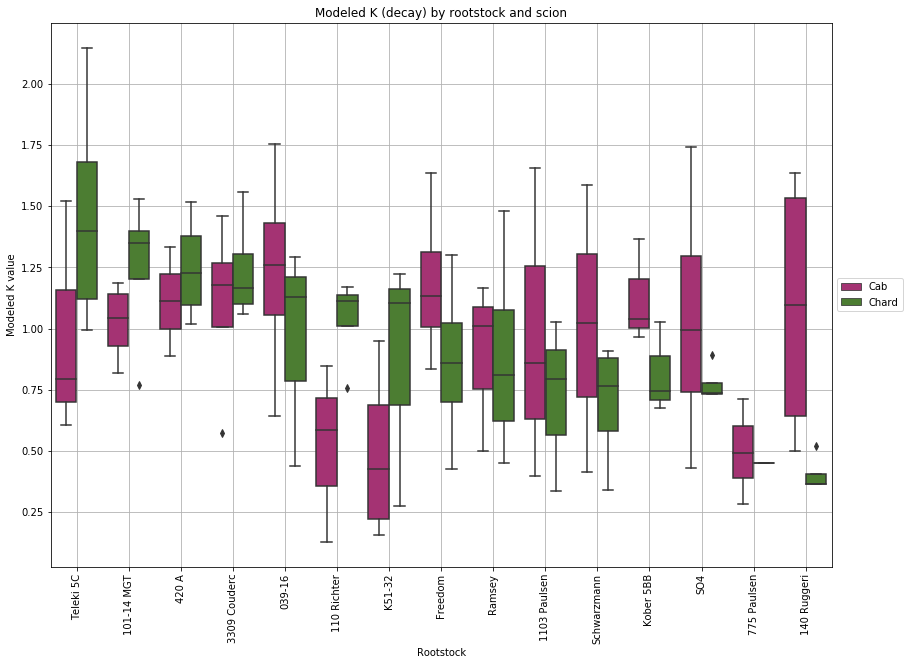

In [13]:
scion_pal = {"Chard": "#498925", "Cab": "#b72076"}

plt.figure(figsize=(14,10))
ax = sns.boxplot(data=df, x="rootstock", y="K", hue="scion", palette=scion_pal,
                    order=["Teleki 5C","101-14 MGT","420 A","3309 Couderc","039-16",
                           "110 Richter","K51-32","Freedom","Ramsey","1103 Paulsen",
                            "Schwarzmann","Kober 5BB", "SO4","775 Paulsen","140 Ruggeri"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.grid()
ax.set_axisbelow(True)
plt.xlabel("Rootstock")
plt.ylabel("Modeled K value")
plt.title("Modeled K (decay) by rootstock and scion")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("FIGURE2G_K.jpg")

## Rename vine for model data and merge with trait data for correlation

In [14]:
# vine name in ring model data has row and block info
# but trait data has only block info in vine name
# we need to rename the ring model vine names to merge with traits

just_model_vals = df[["vine","A","B","K"]]

rows = []

for i in range(len(just_model_vals)):

    s = just_model_vals.iloc[i,0]
    c = "_"

    first_ind = [pos for pos, char in enumerate(s) if char == c][-2]
    second_ind = [pos for pos, char in enumerate(s) if char == c][-1]

    first_half = s[0:first_ind]
    second_half = s[-1]
    
    new_vine = first_half + "_" + second_half
    A_val = just_model_vals.iloc[i,1]
    B_val = just_model_vals.iloc[i,2]
    K_val = just_model_vals.iloc[i,3]
    
    rows.append([new_vine, A_val, B_val, K_val])

model_values = pd.DataFrame(rows, columns=["vine", "A", "B", "K"])


In [15]:
data = pd.merge(trait_data, model_values)

_____
# 2. CORRELATE EACH TRAIT FOR EACH YEAR (1995-1999) WITH EACH RING FEATURE AND MODEL VALUE

1. Create lists of each trait for each year and each scion to correlate with each ring feature and model value
2. Loop through and perform each correlation
3. Double check correlation outputs. Only 5786 correlations because of missing data
4. Spearman's rank correlation coefficient for trait correlations with trunk radius visualized as a boxplot
5. Perform Benjamini-Hochberg multiple test correction. 33 siginificant correlations < 0.05 p-value
6. Plot FDR BH corrected p-values against original p-values. Use -log10(p-value)
7. Print out and inspect significant correlations after mutiple test adjustment
8. Create a pandas dataframe with the trait and scion name, ringe feature or model value, and Spearman's rank correlation coefficient
9. Create a heatmap of significant correlations after multiple test adjustment
_____

## Create lists of each trait for each year and each scion to correlate with each ring feature

In [16]:
# In order to loop through correlations,
# create lists of factor levels for:
# scions, traits, years, and rings
# note: trait_names renames traits to impose order to factor levels

scions = ["Cab","Chard"]
traits = ["soluble_solids_content","titratable_acidity_gL","pH","berry_weight_g",
          "yield_kg","cluster_number","pruning_weight_kg","yield_div_pruning_weight",
         "avg_cluster_weight_g","cluster_divide_berry_weight","bloom_petiole_B_mgL",
         "bloom_petiole_Ca_mgL","bloom_petiole_Cl_mgL","bloom_petiole_Cu_mgL","bloom_petiole_Fe_mgL",
         "bloom_petiole_K_mgL","bloom_petiole_Mg_mgL","bloom_petiole_Mn_mgL","bloom_petiole_Na_mgL",
         "bloom_petiole_NO3_mgL","bloom_petiole_P_mgL","bloom_petiole_S_mgL","bloom_petiole_Zn_mgL",
         "cordon_length_Mvine","shoots_per_linearm","shoots_per_vine","yeast_assimilable_N_mgL"]
trait_names = ["03.soluble_solids_content","titratable_acidity_gL","01.pH","berry_weight_g",
          "02.yield_kg","cluster_number","pruning_weight_kg","00.yield_div_pruning_weight",
         "avg_cluster_weight_g","cluster_divide_berry_weight","bloom_petiole_B_mgL",
         "05.bloom_petiole_Ca_mgL","bloom_petiole_Cl_mgL","bloom_petiole_Cu_mgL","bloom_petiole_Fe_mgL",
         "bloom_petiole_K_mgL","bloom_petiole_Mg_mgL","bloom_petiole_Mn_mgL","bloom_petiole_Na_mgL",
         "bloom_petiole_NO3_mgL","04.bloom_petiole_P_mgL","bloom_petiole_S_mgL","bloom_petiole_Zn_mgL",
         "cordon_length_Mvine","shoots_per_linearm","shoots_per_vine","yeast_assimilable_N_mgL"]
years = [1995, 1996, 1997, 1998, 1999, 2017, 2018, 2019, 2020]
rings = ["early_1","late_1","early_2","late_2","early_3","late_3","early_4","late_4",
         "early_5","late_5","early_6","late_6","early_7","late_7","early_8","late_8",
         "outer_rings","cambium","total_width","A","B","K"]



## Loop through and perform each correlation

In [17]:
#############################################################
# CORRELATE EACH RING FEATURE WITH EACH TRAIT FROM EACH YEAR
#############################################################

from scipy.stats import spearmanr # import to calculate spearman p values
    
def spearmanr_pval(x,y): # create function to calculate spearman p value with pandas .corr
    return spearmanr(x,y)[1]

corr_vals = [] # to store Spearman's rank correlation coefficient
p_vals = [] # to store correlation p-value

scion_output = [] # store scion identity of correlation
trait_output = [] # store trait identity of correlation
year_output = [] # store year identity of correlation
ring_output = [] # store ring feature that was correlated

for s in scions: # loop over and select each scion
    
    scion = data[data["scion"]==s]

    for y in years: # loop over and select each year

        year = scion[scion["year"]==y]
        
        for t in traits: # then, select each trait in turn
        
            trait = year[t]
            trait_ind = traits.index(t) # store the trait index so that it can be renamed
            
            for r in rings:
                
                ring = year[r] # then, select each ring feature in turn
                
                corr_val = trait.corr(ring, method="spearman")
                p_val = trait.corr(ring, method=spearmanr_pval)
                
                if np.isnan(corr_val): # if missing data and nan, pass over and proceed to next correlation
                    
                    pass
                
                else: # if there is a correlation, store the results
                    
                    corr_vals.append(corr_val) # store Spearman's rank correlation coefficient and p value
                    p_vals.append(p_val)

                    scion_output.append(s) # store associated values
                    trait_output.append(trait_names[trait_ind])
                    year_output.append(y)
                    ring_output.append(r)
                    
                    

In [18]:
# print out total number of tests (5786 tests)

print(len(corr_vals))
print(len(p_vals))
print(len(scion_output))
print(len(trait_output))
print(len(year_output))
print(len(ring_output))

5786
5786
5786
5786
5786
5786


## Spearman's rank correlation coefficient for trait correlations with trunk radius visualized as a boxplot

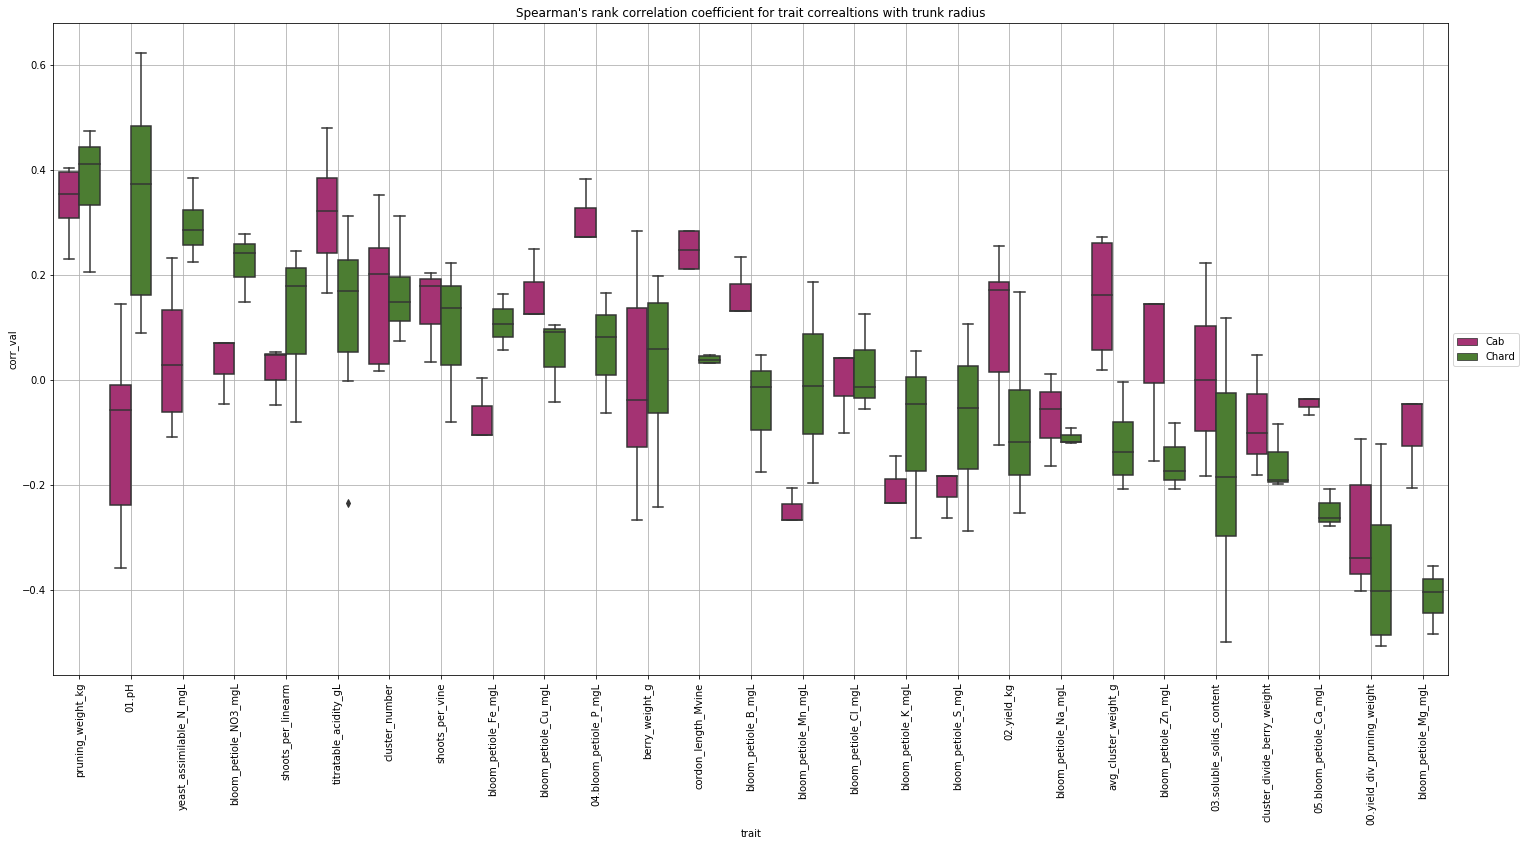

In [19]:
corr_df = pd.DataFrame(
    {"trait":trait_output,
     "ring":ring_output,
     "scion":scion_output,
     "corr_val":corr_vals})

just_total_width = corr_df[corr_df["ring"]=="total_width"]

scion_pal = {"Chard":"#498925","Cab":"#b72076"}
plt.figure(figsize=(25,12))
g = sns.boxplot(data=just_total_width, x="trait", y="corr_val", hue="scion", palette=scion_pal,
               order=["pruning_weight_kg",
                "01.pH",
                "yeast_assimilable_N_mgL",
                "bloom_petiole_NO3_mgL",
                "shoots_per_linearm",
                "titratable_acidity_gL",
                "cluster_number",
                "shoots_per_vine",
                "bloom_petiole_Fe_mgL",
                "bloom_petiole_Cu_mgL",
                "04.bloom_petiole_P_mgL",
                "berry_weight_g",
                "cordon_length_Mvine",
                "bloom_petiole_B_mgL",
                "bloom_petiole_Mn_mgL",
                "bloom_petiole_Cl_mgL",
                "bloom_petiole_K_mgL",
                "bloom_petiole_S_mgL",
                "02.yield_kg",
                "bloom_petiole_Na_mgL",
                "avg_cluster_weight_g",
                "bloom_petiole_Zn_mgL",
                "03.soluble_solids_content",
                "cluster_divide_berry_weight",
                "05.bloom_petiole_Ca_mgL",
                "00.yield_div_pruning_weight",
                "bloom_petiole_Mg_mgL"])

g.tick_params(axis='x', labelrotation=90)
g.set_axisbelow(True)
g.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Spearman's rank correlation coefficient for trait correaltions with trunk radius")

plt.savefig("FIGURE3A.jpg")


## Perform Benjamini-Hochberg multiple test correction. 33 siginificant correlations < 0.05 p-value

In [20]:
multitest_pvals = multitest.multipletests(p_vals, method="fdr_bh")[1]

sum(multitest_pvals<0.05)


33

## Plot FDR BH corrected p-values against original p-values. Use -log10(p-value)

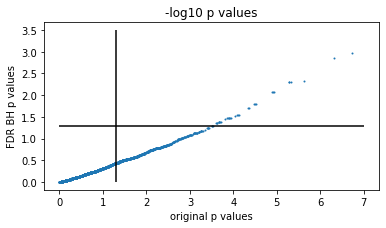

In [21]:
plt.scatter(-np.log10(p_vals), -np.log10(multitest_pvals), s=1)

plt.vlines(-np.log10(0.05),0,3.5)
plt.hlines(-np.log10(0.05),0,7)
plt.xlabel("original p values")
plt.ylabel("FDR BH p values")
plt.title("-log10 p values")
plt.gca().set_aspect("equal")


## Print out and inspect significant correlations after mutiple test adjustment

In [22]:
for i in range(len(multitest_pvals)):
    
    if multitest_pvals[i] < 0.05:
        
        scion = scion_output[i]
        trait = trait_output[i]
        year = year_output[i]
        ring = ring_output[i]
        
        print(-np.log10(multitest_pvals[i]),corr_vals[i],scion, trait, year, ring)

1.3781084686031806 -0.49732938259893794 Cab 01.pH 1999 A
1.3781084686031806 0.5589101705165167 Cab 04.bloom_petiole_P_mgL 2018 early_3
1.3781084686031806 0.5589101705165167 Cab 04.bloom_petiole_P_mgL 2019 early_3
1.450722963641849 -0.5103173800162214 Chard 02.yield_kg 1995 late_4
1.3585682537464034 -0.4968652178617739 Chard 02.yield_kg 1995 late_8
1.4761622349909789 -0.5131578947368421 Chard 00.yield_div_pruning_weight 1995 late_2
1.7916848326286723 -0.5511909335382251 Chard 00.yield_div_pruning_weight 1995 late_3
2.0790123038923882 -0.57520169035728 Chard 00.yield_div_pruning_weight 1995 late_4
1.4776352050765114 -0.5187283903188629 Chard 00.yield_div_pruning_weight 1995 late_5
2.2909152984995496 -0.5945063388398002 Chard 00.yield_div_pruning_weight 1995 late_6
1.5511183779294058 -0.5291970802919709 Chard 00.yield_div_pruning_weight 1995 late_8
2.0790123038923882 0.5555583406066475 Chard 01.pH 1996 outer_rings
2.3325596433408666 0.5920559886014218 Chard 01.pH 1996 total_width
2.962500

## Create a pandas dataframe with the trait and scion name, ringe feature, and Spearman's rank correlation coefficient and p-value

In [23]:
rows = []

for i in range(len(multitest_pvals)):
    
    if multitest_pvals[i] < 0.05: 
        
        corr_val = corr_vals[i]
        
        scion = scion_output[i]
        trait = trait_output[i]
        year = year_output[i]
        ring = ring_output[i]
        
        name = trait + "." + scion + "." + str(year)
        
        rows.append([name, ring, corr_val])
        
df = pd.DataFrame(rows, columns=["trait_name", "ring", "corr"])

## Create a heatmap of significant correlations after multiple test adjustment

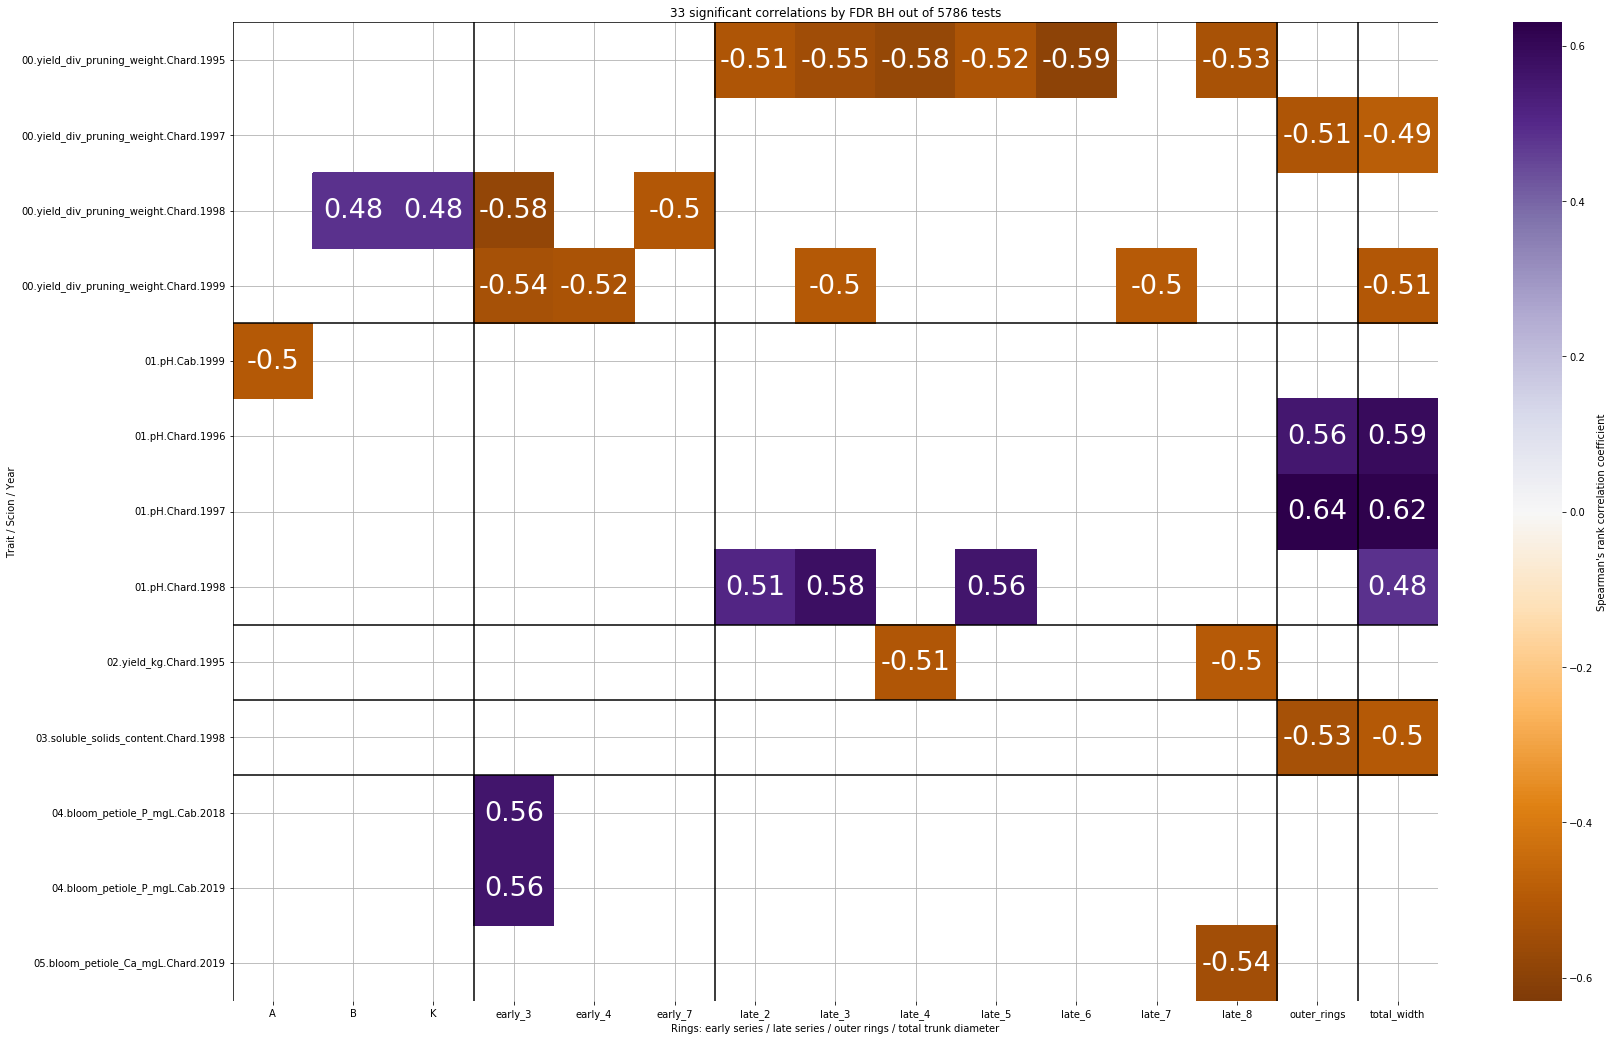

In [24]:
heatmap_table = df.pivot("trait_name","ring","corr")
f, ax = plt.subplots(figsize=(27, 18))
h = sns.heatmap(heatmap_table, annot=True,  linewidths=0, ax=ax, center=0, cmap="PuOr",
                vmin=-0.63, vmax=0.63,
                cbar_kws={'label': "Spearman's rank correlation coefficient"},
                annot_kws={"size": 27})
plt.grid()
ax.set_axisbelow(True)
h.set_xlabel('Rings: early series / late series / outer rings / total trunk diameter', fontsize=10)
h.set_ylabel('Trait / Scion / Year', fontsize=10)
plt.vlines([0,3,6,13,14], 0, 24)
plt.hlines([0,4,8,9,10], 0, 18)
plt.title("33 significant correlations by FDR BH out of 5786 tests")
plt.savefig("FIGURE3B.jpg", bbox_inches="tight")


**The traits with the most significant correlations are:**

Ravaz index: 17  
pH: 9  
Yield: 2  
Soluble solids: 2   
Bloom petiole P: 2  
Bloom petiole Ca: 1

_______
# 3. CALCULATE AND VISUALIZE THE PERCENT CONTRIBUTION OF ROOTSTOCK TO TRUNK RADIUS IN CHARDONNAY AND CABERNET SAUVIGNON

1. Scion explains 47.45% variation in total trunk width
2. Rootstock expains 16.6% variation in total trunk width
3. Scion\*Rootstock expains 2.36% variation in total trunk width
4. Visualize scion and rootstock trunk radius as a boxplot
________

In [25]:
data_1995 = data[(data["year"]==1995)] # select one year to remove redundancy

total_width_lm = ols("total_width~scion*rootstock", data=data_1995).fit() # perform one-way ANOVA
sm.stats.anova_lm(total_width_lm) # print out ANOVA results

,df,sum_sq,mean_sq,F,PR(>F)
scion,1.0,24.481493,24.481493,105.970460,5.367546e-16
rootstock,14.0,8.564872,0.611777,2.648133,3.495793e-03
scion:rootstock,14.0,1.215902,0.086850,0.375939,9.778609e-01
Residual,75.0,17.326640,0.231022,NaN,NaN


In [26]:
# calculate the percent variation of total trunk width explained by rootstock

total_var = 24.481493+8.564872+1.215902+17.326640

print("Scion explains", round(24.481493/total_var*100,2), "percent variation in total trunk width")
print("Rootstock explains", round(8.564872/total_var*100,2), "percent variation in total trunk width")
print("Scion*Rootstock interaction explains", round(1.215902/total_var*100,2), "percent variation in total trunk width")



Scion explains 47.45 percent variation in total trunk width
Rootstock explains 16.6 percent variation in total trunk width
Scion*Rootstock interaction explains 2.36 percent variation in total trunk width


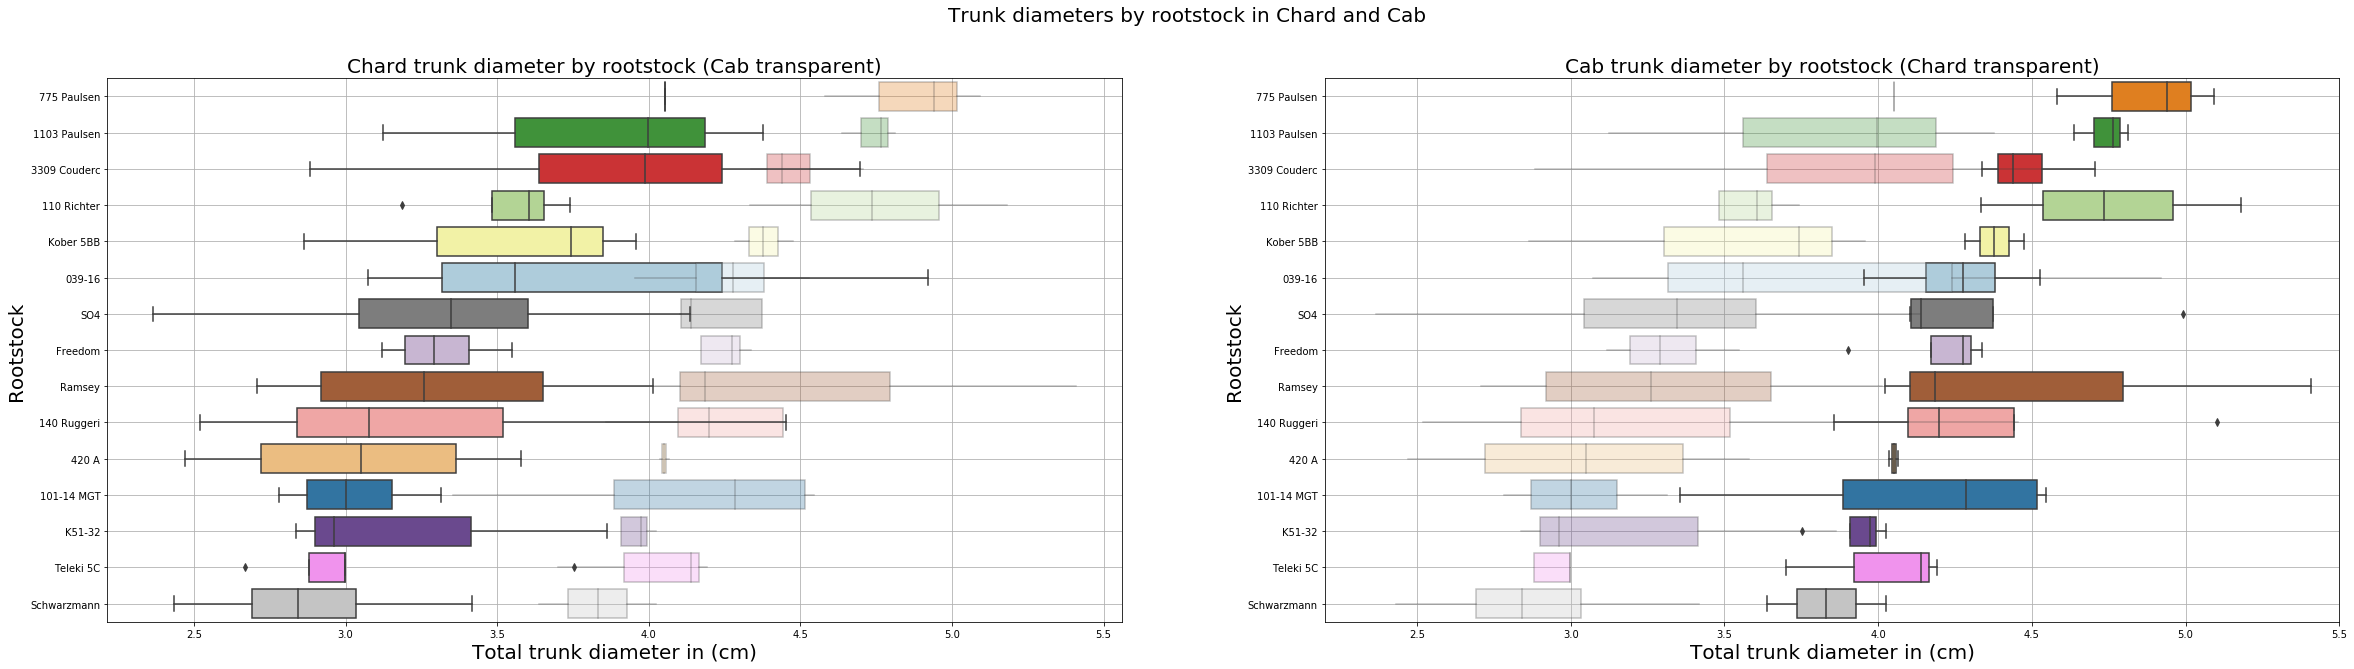

In [27]:
#################
# SET UP SUBPLOTS
#################

fig, axes = plt.subplots(1,2,figsize=(40,10))
fig.suptitle("Trunk diameters by rootstock in Chard and Cab", fontsize=20)

############################################################################
# CREATE SUBPLOT OF CHARD TRUNK DIAMETER BY ROOTSTOCK (WITH CAB TRANSPARENT)
############################################################################

data_chard_1995 = data_1995[(data_1995["scion"]=="Chard")] # select chardonnay for one year
data_cab_1995 = data_1995[(data_1995["scion"]=="Cab")] # select cabernet for one year

chard_order = ["775 Paulsen","1103 Paulsen","3309 Couderc","110 Richter",
                           "Kober 5BB","039-16","SO4","Freedom","Ramsey","140 Ruggeri",
                           "420 A","101-14 MGT","K51-32","Teleki 5C","Schwarzmann"] # order based on chardonnay values

rootstock_pal = {'039-16':"#a6cee3",'101-14 MGT':"#1f78b4",'110 Richter':"#b2df8a",'1103 Paulsen':"#33a02c",
                 '140 Ruggeri':"#fb9a99",'3309 Couderc':"#e31a1c",'420 A':"#fdbf6f",'775 Paulsen':"#ff7f00",
                 'Freedom':"#cab2d6",'K51-32':"#6a3d9a",'Kober 5BB':"#ffff99",'Ramsey':"#b15928",'SO4':"#7D7D7D",
                 'Schwarzmann':"#C4C4C4",'Teleki 5C':"#FF83FC"} # rootstock color palette

sns.boxplot(ax=axes[0],data=data_chard_1995, x="total_width", y="rootstock",
                    order=chard_order, palette=rootstock_pal)
sns.boxplot(ax=axes[0],data=data_cab_1995, x="total_width", y="rootstock",
                    order=chard_order, 
                    boxprops=dict(alpha=.3),whiskerprops=dict(alpha=.3),capprops=dict(alpha=0),
                    flierprops=dict(alpha=0),medianprops=dict(alpha=.3), palette=rootstock_pal)
#sns.swarmplot(ax=axes[0],data=data_chard_1995, x="total_width", y="rootstock", color="0.25", zorder=10, order=chard_order)
axes[0].set_xlabel('Total trunk diameter in (cm)', fontsize=20)
axes[0].set_ylabel('Rootstock', fontsize=20)
axes[0].set_title('Chard trunk diameter by rootstock (Cab transparent)', fontsize=20)
plt.xlim(2.2, 5.5)
axes[0].grid()
axes[0].set_axisbelow(True)

############################################################################
# CREATE SUBPLOT OF CAB TRUNK DIAMETER BY ROOTSTOCK (WITH CHARD TRANSPARENT)
############################################################################

sns.boxplot(ax=axes[1],data=data_cab_1995, x="total_width", y="rootstock",
                    order=chard_order, palette=rootstock_pal)
sns.boxplot(ax=axes[1],data=data_chard_1995, x="total_width", y="rootstock",
                    order=chard_order, 
                    boxprops=dict(alpha=.3),whiskerprops=dict(alpha=.3),capprops=dict(alpha=0),
                    flierprops=dict(alpha=0),medianprops=dict(alpha=.3), palette=rootstock_pal)
#sns.swarmplot(ax=axes[1],data=data_cab_1995, x="total_width", y="rootstock", color="0.25", zorder=10, order=chard_order)
axes[1].set_xlabel('Total trunk diameter in (cm)', fontsize=20)
axes[1].set_ylabel('Rootstock', fontsize=20)
axes[1].set_title('Cab trunk diameter by rootstock (Chard transparent)', fontsize=20)
plt.xlim(2.2, 5.5)
axes[1].grid()
axes[1].set_axisbelow(True)

plt.savefig("FIGURE1B_TRUNK_RADIUS.jpg", bbox_inches="tight")


_____
# 4. PH AND TRUNK RADIUS (cm)
_______

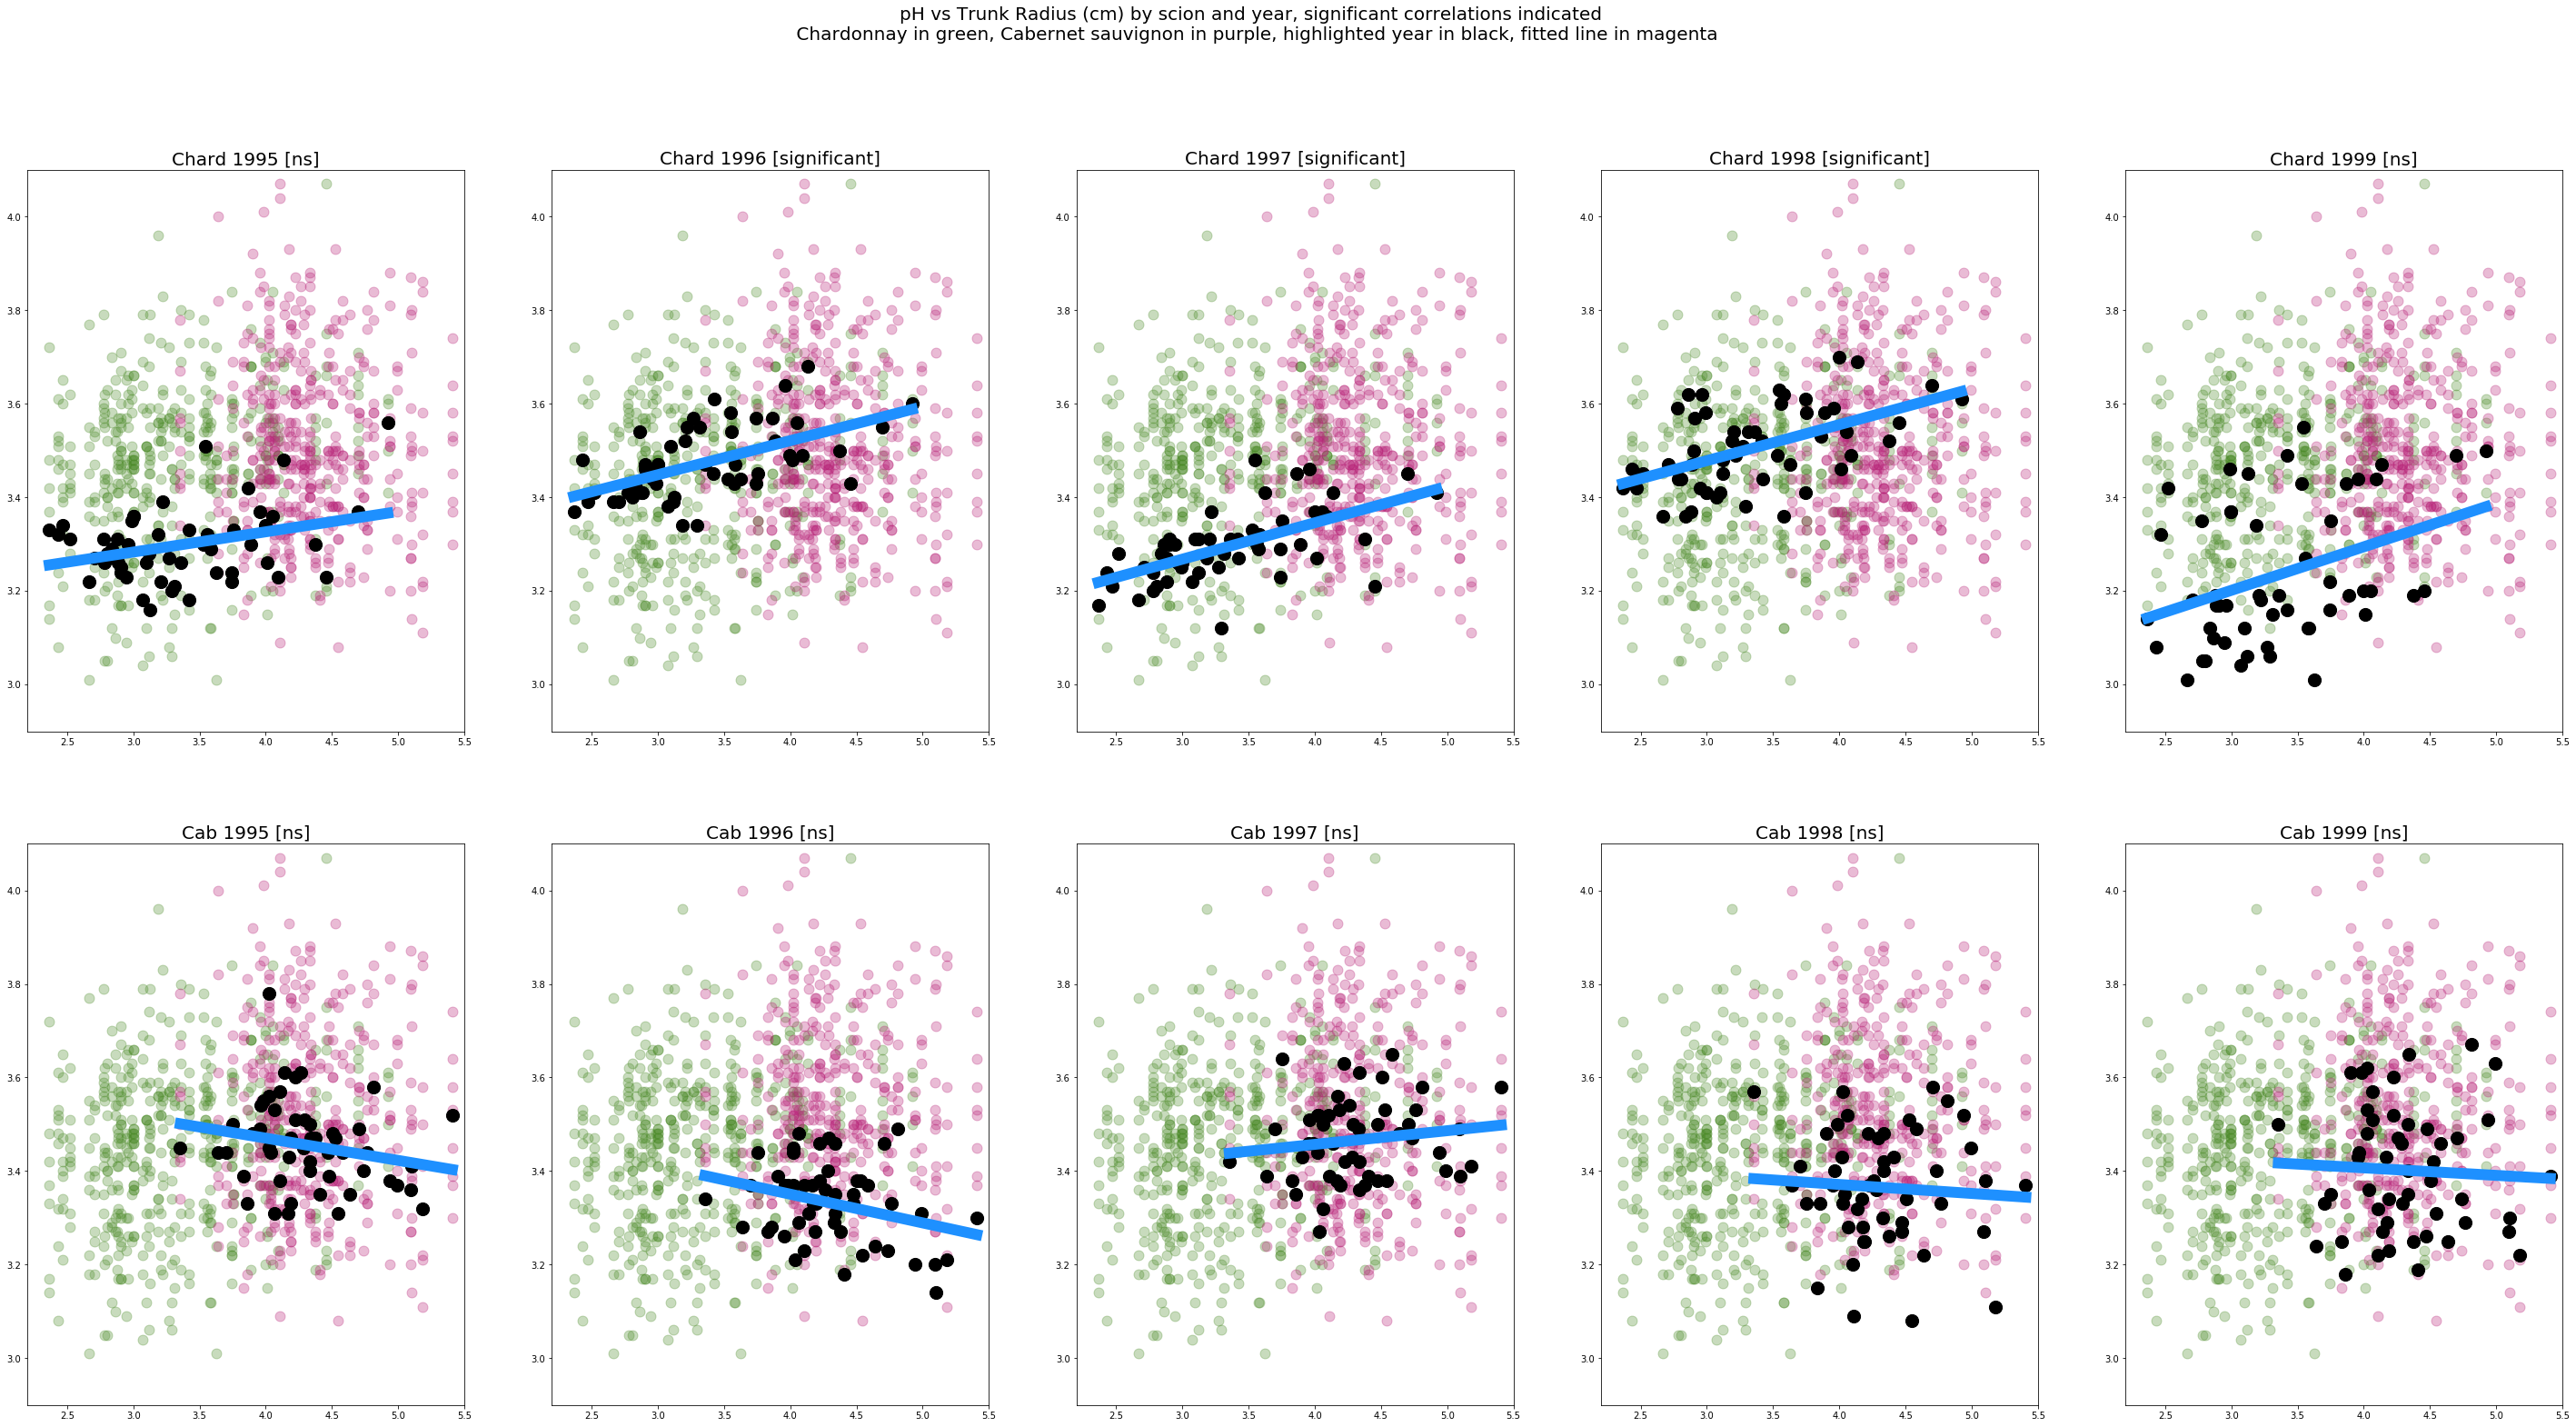

In [28]:
sel_trait = "pH" # select the trait to make aa plot for

############################################################
# SELECT CHARDONNAY AND CABERNET SAUVIGNON DATA BY EACH YEAR
############################################################

data_chard = data[(data["scion"]=="Chard")] # select just chardonnay data with a mask
data_chard_1995 = data_chard[(data_chard["year"]==1995)] # select each year of chardonnay data with a mask
data_chard_1996 = data_chard[(data_chard["year"]==1996)]
data_chard_1997 = data_chard[(data_chard["year"]==1997)]
data_chard_1998 = data_chard[(data_chard["year"]==1998)]
data_chard_1999 = data_chard[(data_chard["year"]==1999)]

data_cab = data[(data["scion"]=="Cab")] # select just cabernet sauvignon data with a mask
data_cab_1995 = data_cab[(data_cab["year"]==1995)] # select each year of cabernet sauvignon data with a mask
data_cab_1996 = data_cab[(data_cab["year"]==1996)]
data_cab_1997 = data_cab[(data_cab["year"]==1997)]
data_cab_1998 = data_cab[(data_cab["year"]==1998)]
data_cab_1999 = data_cab[(data_cab["year"]==1999)]

#############################################################
# MODEL DATA AS LINEAR FUNCTIONN FOR EACH SCION FOR EACH YEAR
#############################################################

chard1995_func = np.poly1d(np.polyfit(data_chard_1995["total_width"],data_chard_1995[sel_trait],1))
chard1996_func = np.poly1d(np.polyfit(data_chard_1996["total_width"],data_chard_1996[sel_trait],1))
chard1997_func = np.poly1d(np.polyfit(data_chard_1997["total_width"],data_chard_1997[sel_trait],1))
chard1998_func = np.poly1d(np.polyfit(data_chard_1998["total_width"],data_chard_1998[sel_trait],1))
chard1999_func = np.poly1d(np.polyfit(data_chard_1998["total_width"],data_chard_1999[sel_trait],1))
cab1995_func = np.poly1d(np.polyfit(data_cab_1995["total_width"],data_cab_1995[sel_trait],1))
cab1996_func = np.poly1d(np.polyfit(data_cab_1996["total_width"],data_cab_1996[sel_trait],1))
cab1997_func = np.poly1d(np.polyfit(data_cab_1997["total_width"],data_cab_1997[sel_trait],1))
cab1998_func = np.poly1d(np.polyfit(data_cab_1998["total_width"],data_cab_1998[sel_trait],1))
cab1999_func = np.poly1d(np.polyfit(data_cab_1998["total_width"],data_cab_1999[sel_trait],1))

#####################
# SET PLOT PARAMETERS
#####################

low_x = 2.2 # lower x axis limit 
high_x = 5.5 # upper x axis limit 
low_y = 2.9 # lower y axis limit 
high_y = 4.1 # upper y axis limit 
alpha_bg = 0.3 # alpha chard/cab background data 
col_chard = "#498925" # color chardonnay 
col_cab = "#b72076" # color cabernet 
col_sel = "k" # selected data color 
col_fit = "dodgerblue" # fitted line color
s_sel = 200 # selected data size
s_bg = 120 # background data size
lw_fit = 12 # fitted line width
fs_suptitle = 20 # main title fontsize
fs_subtitle = 20 # subtitle fontsize

###############
# PLOT THE DATA
###############

plt.figure(figsize=(50,25)) # set overall figure size

# Chardonnay

plt.subplot(2,5,1) # Chard 1995
plt.scatter(data_chard_1995["total_width"],data_chard_1995[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1995["total_width"]),np.max(data_chard_1995["total_width"]),100),
        chard1995_func(np.linspace(np.min(data_chard_1995["total_width"]),np.max(data_chard_1995["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1995 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,2) # Chard 1996
plt.scatter(data_chard_1996["total_width"],data_chard_1996[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1996["total_width"]),np.max(data_chard_1996["total_width"]),100),
        chard1996_func(np.linspace(np.min(data_chard_1996["total_width"]),np.max(data_chard_1996["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1996 [significant]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,3) # Chard 1997
plt.scatter(data_chard_1997["total_width"],data_chard_1997[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1997["total_width"]),np.max(data_chard_1997["total_width"]),100),
        chard1997_func(np.linspace(np.min(data_chard_1997["total_width"]),np.max(data_chard_1997["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1997 [significant]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,4) # Chard 1998
plt.scatter(data_chard_1998["total_width"],data_chard_1998[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1998["total_width"]),np.max(data_chard_1998["total_width"]),100),
        chard1998_func(np.linspace(np.min(data_chard_1998["total_width"]),np.max(data_chard_1998["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1998 [significant]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,5) # Chard 1999
plt.scatter(data_chard_1999["total_width"],data_chard_1999[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1999["total_width"]),np.max(data_chard_1999["total_width"]),100),
        chard1999_func(np.linspace(np.min(data_chard_1999["total_width"]),np.max(data_chard_1999["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1999 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

# Cabernet

plt.subplot(2,5,6) # Cab 1995
plt.scatter(data_cab_1995["total_width"],data_cab_1995[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1995["total_width"]),np.max(data_cab_1995["total_width"]),100),
        cab1995_func(np.linspace(np.min(data_cab_1995["total_width"]),np.max(data_cab_1995["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1995 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,7) # Cab 1996
plt.scatter(data_cab_1996["total_width"],data_cab_1996[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1996["total_width"]),np.max(data_cab_1996["total_width"]),100),
        cab1996_func(np.linspace(np.min(data_cab_1996["total_width"]),np.max(data_cab_1996["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1996 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,8) # Cab 1997
plt.scatter(data_cab_1997["total_width"],data_cab_1997[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1997["total_width"]),np.max(data_cab_1997["total_width"]),100),
        cab1997_func(np.linspace(np.min(data_cab_1997["total_width"]),np.max(data_cab_1997["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1997 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,9) # Cab 1998
plt.scatter(data_cab_1998["total_width"],data_cab_1998[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1998["total_width"]),np.max(data_cab_1998["total_width"]),100),
        cab1998_func(np.linspace(np.min(data_cab_1998["total_width"]),np.max(data_cab_1998["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1998 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,10) # Cab 1999
plt.scatter(data_cab_1999["total_width"],data_cab_1999[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1999["total_width"]),np.max(data_cab_1999["total_width"]),100),
        cab1999_func(np.linspace(np.min(data_cab_1999["total_width"]),np.max(data_cab_1999["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1999 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

# set overall plot title
plt.suptitle("pH vs Trunk Radius (cm) by scion and year, significant correlations indicated \n Chardonnay in green, Cabernet sauvignon in purple, highlighted year in black, fitted line in magenta", fontsize=fs_suptitle)
plt.savefig("FIGURE4B.jpg", bbox_inches="tight")

_____
# 6. RAVAZ INDEX (YIELD DIVIDED BY PRUNING WEIGHT) AND TRUNK RADIUS (cm)
_______

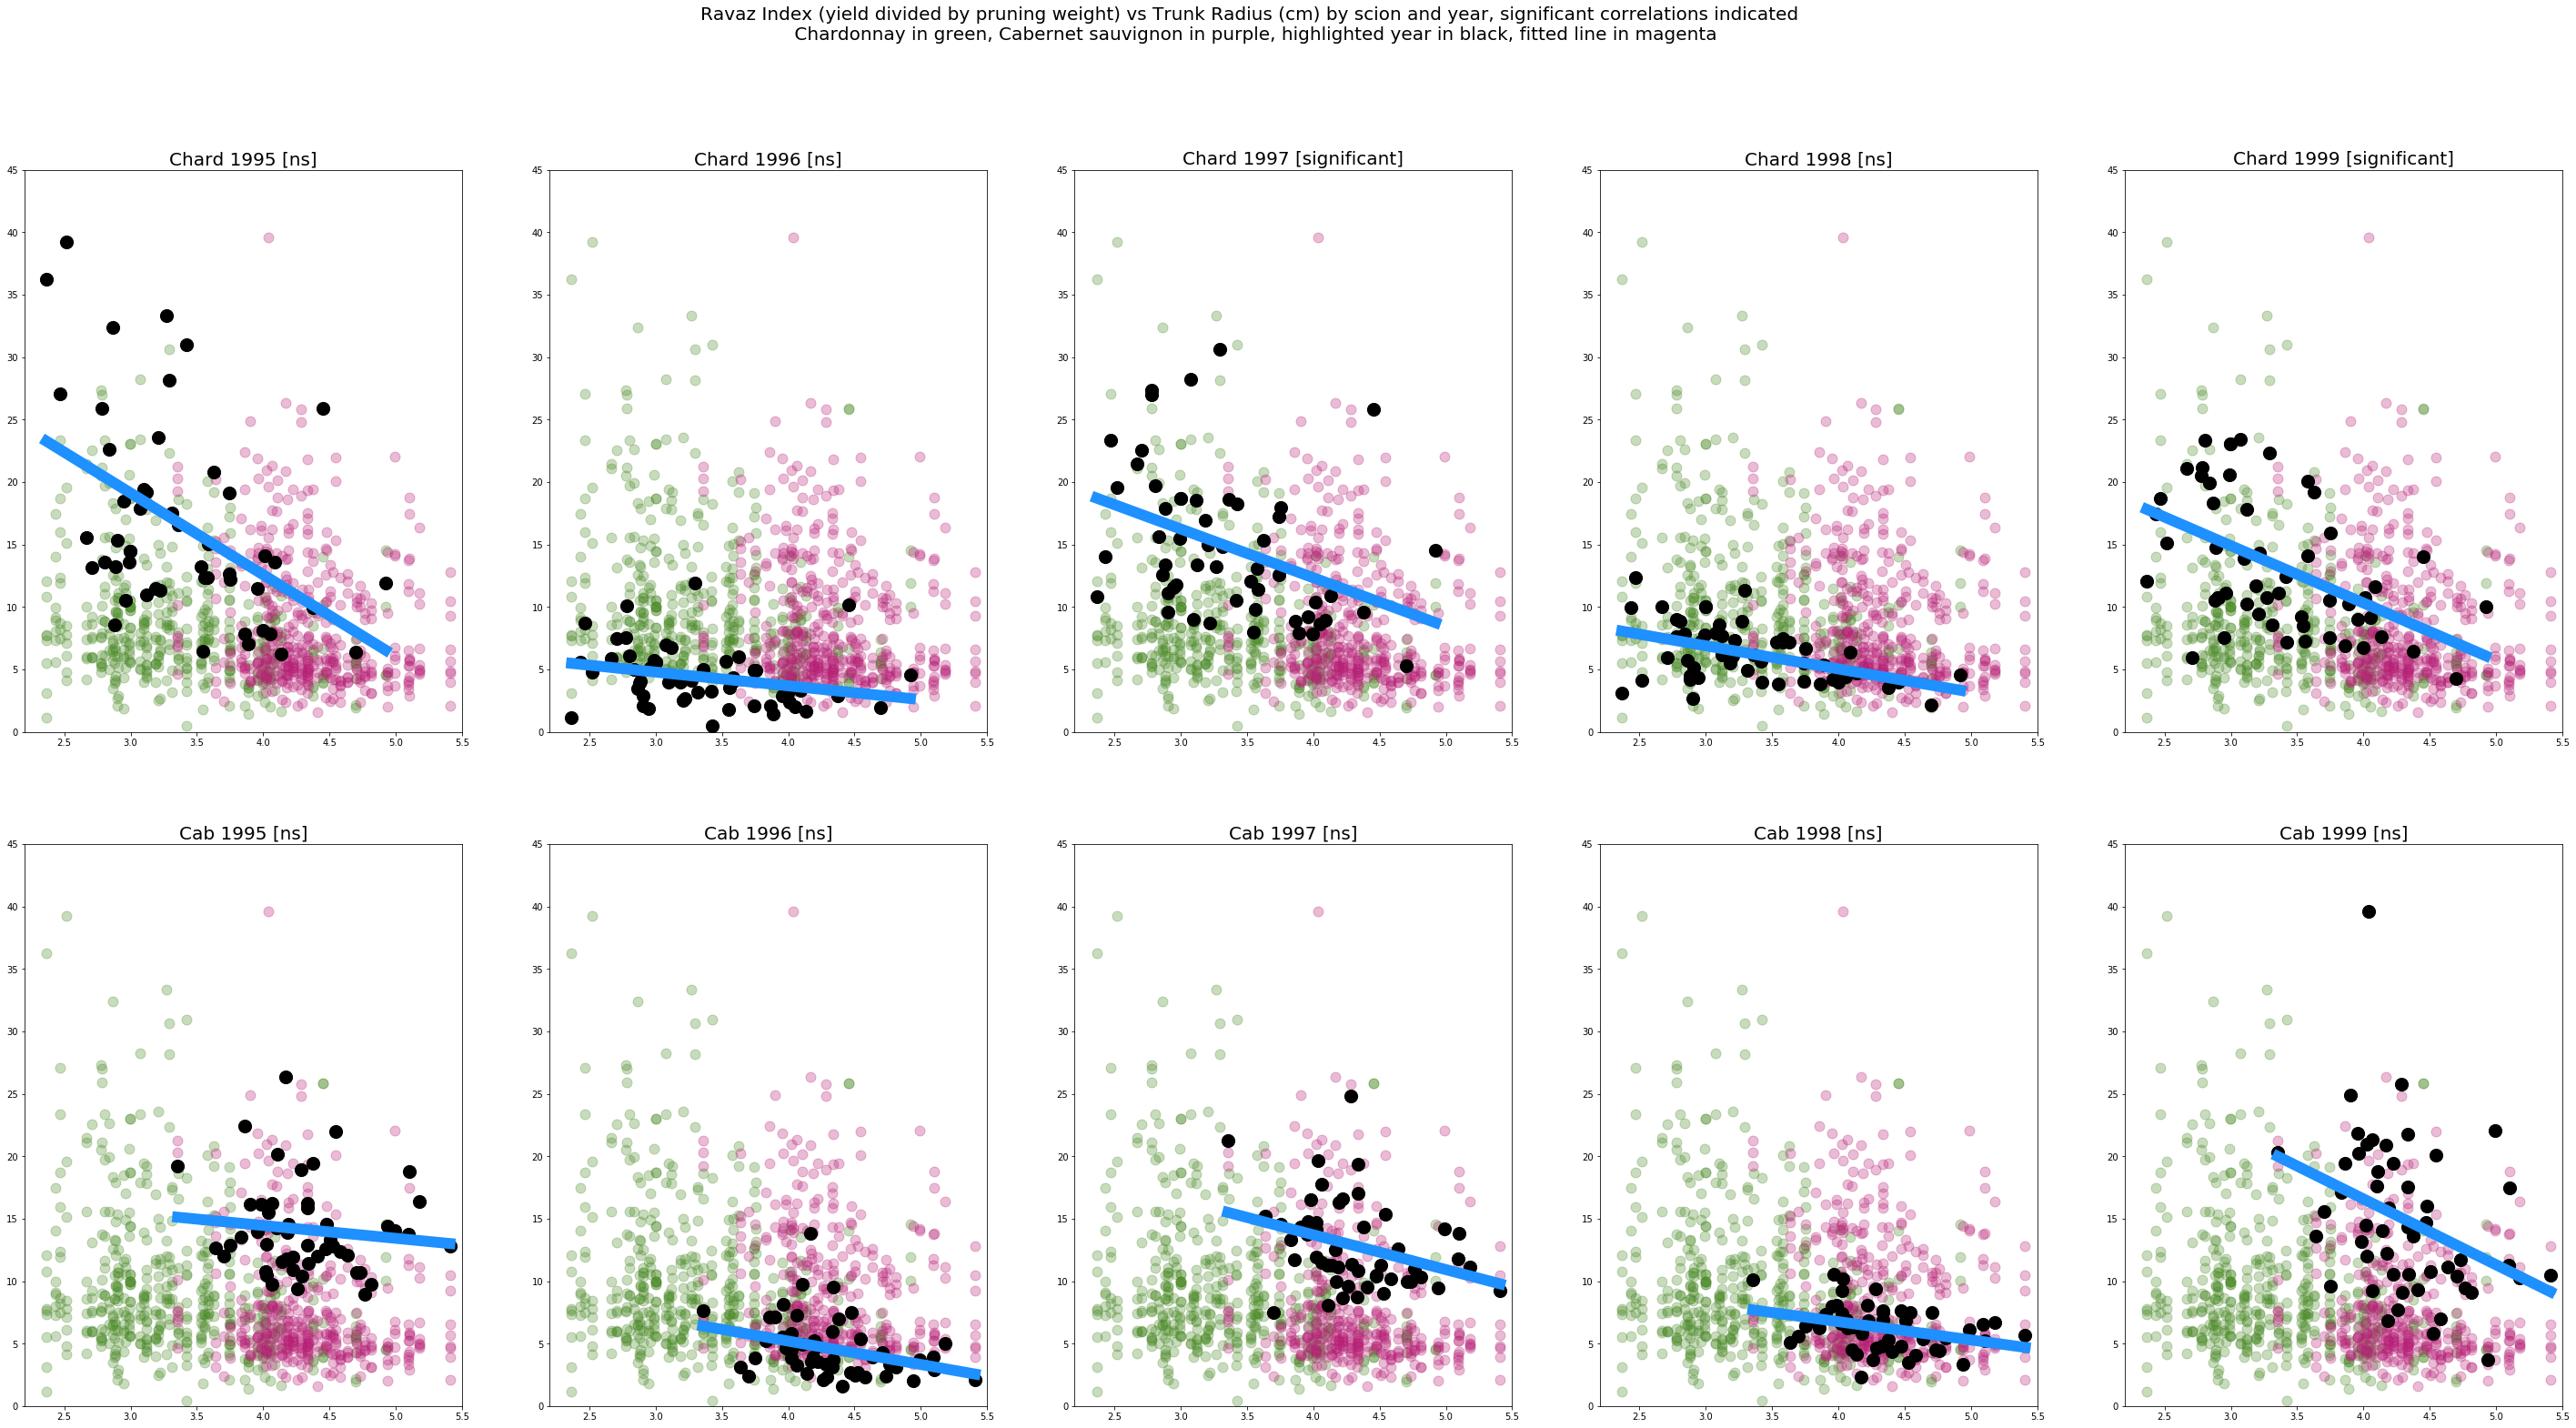

In [29]:
sel_trait = "yield_div_pruning_weight" # select the trait to make aa plot for

############################################################
# SELECT CHARDONNAY AND CABERNET SAUVIGNON DATA BY EACH YEAR
############################################################

data_chard = data[(data["scion"]=="Chard")] # select just chardonnay data with a mask
data_chard_1995 = data_chard[(data_chard["year"]==1995)] # select each year of chardonnay data with a mask
data_chard_1996 = data_chard[(data_chard["year"]==1996)]
data_chard_1997 = data_chard[(data_chard["year"]==1997)]
data_chard_1998 = data_chard[(data_chard["year"]==1998)]
data_chard_1999 = data_chard[(data_chard["year"]==1999)]

data_cab = data[(data["scion"]=="Cab")] # select just cabernet sauvignon data with a mask
data_cab_1995 = data_cab[(data_cab["year"]==1995)] # select each year of cabernet sauvignon data with a mask
data_cab_1996 = data_cab[(data_cab["year"]==1996)]
data_cab_1997 = data_cab[(data_cab["year"]==1997)]
data_cab_1998 = data_cab[(data_cab["year"]==1998)]
data_cab_1999 = data_cab[(data_cab["year"]==1999)]

#############################################################
# MODEL DATA AS LINEAR FUNCTIONN FOR EACH SCION FOR EACH YEAR
#############################################################

# remove nan's from data_chard_1995
idx_chard1995 = np.isfinite(data_chard_1995["total_width"]) & np.isfinite(data_chard_1995[sel_trait])
chard1995_func = np.poly1d(np.polyfit(data_chard_1995["total_width"][idx_chard1995],data_chard_1995[sel_trait][idx_chard1995],1))
chard1996_func = np.poly1d(np.polyfit(data_chard_1996["total_width"],data_chard_1996[sel_trait],1))
chard1997_func = np.poly1d(np.polyfit(data_chard_1997["total_width"],data_chard_1997[sel_trait],1))
# remove nan's from data_chard_1998
idx_chard1998 = np.isfinite(data_chard_1998["total_width"]) & np.isfinite(data_chard_1998[sel_trait])
chard1998_func = np.poly1d(np.polyfit(data_chard_1998["total_width"][idx_chard1998],data_chard_1998[sel_trait][idx_chard1998],1))
chard1999_func = np.poly1d(np.polyfit(data_chard_1998["total_width"],data_chard_1999[sel_trait],1))
cab1995_func = np.poly1d(np.polyfit(data_cab_1995["total_width"],data_cab_1995[sel_trait],1))
cab1996_func = np.poly1d(np.polyfit(data_cab_1996["total_width"],data_cab_1996[sel_trait],1))
cab1997_func = np.poly1d(np.polyfit(data_cab_1997["total_width"],data_cab_1997[sel_trait],1))
cab1998_func = np.poly1d(np.polyfit(data_cab_1998["total_width"],data_cab_1998[sel_trait],1))
cab1999_func = np.poly1d(np.polyfit(data_cab_1998["total_width"],data_cab_1999[sel_trait],1))

#####################
# SET PLOT PARAMETERS
#####################

low_x = 2.2 # lower x axis limit 
high_x = 5.5 # upper x axis limit 
low_y = 0 # lower y axis limit 
high_y = 45 # upper y axis limit 
alpha_bg = 0.3 # alpha chard/cab background data 
col_chard = "#498925" # color chardonnay 
col_cab = "#b72076" # color cabernet 
col_sel = "k" # selected data color 
col_fit = "dodgerblue" # fitted line color
s_sel = 200 # selected data size
s_bg = 120 # background data size
lw_fit = 12 # fitted line width
fs_suptitle = 20 # main title fontsize
fs_subtitle = 20 # subtitle fontsize

###############
# PLOT THE DATA
###############

plt.figure(figsize=(50,25)) # set overall figure size

# Chardonnay

plt.subplot(2,5,1) # Chard 1995
plt.scatter(data_chard_1995["total_width"],data_chard_1995[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1995["total_width"]),np.max(data_chard_1995["total_width"]),100),
        chard1995_func(np.linspace(np.min(data_chard_1995["total_width"]),np.max(data_chard_1995["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1995 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,2) # Chard 1996
plt.scatter(data_chard_1996["total_width"],data_chard_1996[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1996["total_width"]),np.max(data_chard_1996["total_width"]),100),
        chard1996_func(np.linspace(np.min(data_chard_1996["total_width"]),np.max(data_chard_1996["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1996 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,3) # Chard 1997
plt.scatter(data_chard_1997["total_width"],data_chard_1997[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1997["total_width"]),np.max(data_chard_1997["total_width"]),100),
        chard1997_func(np.linspace(np.min(data_chard_1997["total_width"]),np.max(data_chard_1997["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1997 [significant]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,4) # Chard 1998
plt.scatter(data_chard_1998["total_width"],data_chard_1998[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1998["total_width"]),np.max(data_chard_1998["total_width"]),100),
        chard1998_func(np.linspace(np.min(data_chard_1998["total_width"]),np.max(data_chard_1998["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1998 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,5) # Chard 1999
plt.scatter(data_chard_1999["total_width"],data_chard_1999[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_chard_1999["total_width"]),np.max(data_chard_1999["total_width"]),100),
        chard1999_func(np.linspace(np.min(data_chard_1999["total_width"]),np.max(data_chard_1999["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Chard 1999 [significant]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

# Cabernet

plt.subplot(2,5,6) # Cab 1995
plt.scatter(data_cab_1995["total_width"],data_cab_1995[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1995["total_width"]),np.max(data_cab_1995["total_width"]),100),
        cab1995_func(np.linspace(np.min(data_cab_1995["total_width"]),np.max(data_cab_1995["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1995 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,7) # Cab 1996
plt.scatter(data_cab_1996["total_width"],data_cab_1996[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1996["total_width"]),np.max(data_cab_1996["total_width"]),100),
        cab1996_func(np.linspace(np.min(data_cab_1996["total_width"]),np.max(data_cab_1996["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1996 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,8) # Cab 1997
plt.scatter(data_cab_1997["total_width"],data_cab_1997[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1997["total_width"]),np.max(data_cab_1997["total_width"]),100),
        cab1997_func(np.linspace(np.min(data_cab_1997["total_width"]),np.max(data_cab_1997["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1997 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,9) # Cab 1998
plt.scatter(data_cab_1998["total_width"],data_cab_1998[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1998["total_width"]),np.max(data_cab_1998["total_width"]),100),
        cab1998_func(np.linspace(np.min(data_cab_1998["total_width"]),np.max(data_cab_1998["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1998 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

plt.subplot(2,5,10) # Cab 1999
plt.scatter(data_cab_1999["total_width"],data_cab_1999[sel_trait],zorder=2,c=col_sel,s=s_sel)
plt.plot(np.linspace(np.min(data_cab_1999["total_width"]),np.max(data_cab_1999["total_width"]),100),
        cab1999_func(np.linspace(np.min(data_cab_1999["total_width"]),np.max(data_cab_1999["total_width"]),100)),
        c=col_fit, lw=lw_fit)
plt.scatter(data_chard["total_width"],data_chard[sel_trait],zorder=1,alpha=alpha_bg,c=col_chard,s=s_bg)
plt.scatter(data_cab["total_width"],data_cab[sel_trait],zorder=1,alpha=alpha_bg,c=col_cab,s=s_bg)
plt.title("Cab 1999 [ns]", fontsize=fs_subtitle)
plt.xlim(low_x, high_x)
plt.ylim(low_y, high_y)

# set overall plot title
plt.suptitle("Ravaz Index (yield divided by pruning weight) vs Trunk Radius (cm) by scion and year, significant correlations indicated \n Chardonnay in green, Cabernet sauvignon in purple, highlighted year in black, fitted line in magenta", fontsize=fs_suptitle)
plt.savefig("FIGURE4A.jpg", bbox_inches="tight")

_____
# 7. REPEATED MEASURES CORRELATION ON PHYSIOLOGY TRAITS AND TRUNK RADIUS (cm)
_______

## Merge datasets and reorder dates correctly

In [30]:
# merge physiology data with ring width data

merged_phys = pd.merge(phys_data, ring_data)

# mask chardonnay and cabernet sauvignon separately

chard_phys = merged_phys[ merged_phys["Scion"]=="Chard" ]
cab_phys = merged_phys[ merged_phys["Scion"]=="Cab" ]

# reorder dates

chard_phys["Date"] = chard_phys["Date"].astype('category')
cab_phys["Date"] = cab_phys["Date"].astype('category')

chard_phys["Date"].cat.reorder_categories(['6/19/18','6/26/18','7/3/18','7/10/18','7/17/18','7/24/18','7/31/18','8/6/18','6/17/19','6/25/19','7/1/19','7/17/19','7/9/19','7/23/19','7/29/19'], inplace=True)
cab_phys["Date"].cat.reorder_categories(['6/19/18','6/26/18','7/3/18','7/10/18','7/17/18','7/24/18','7/31/18','8/6/18','6/17/19','6/25/19','7/1/19','7/17/19','7/9/19','7/23/19','7/29/19'], inplace=True)


/Users/chitwood/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/chitwood/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/chitwood/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reorder

## Perform repeated measures correlation, where each date measuring three rootstocks is the repeated measure

## Chardonnay, A, Assimilation rate, µmol m-2 s-1

In [31]:
## Chardonnay, A
### Assimilation rate, µmol m-2 s-1
### r = 0.332799
### p = 4.896833e-08

pg.rm_corr(data=chard_phys, x="total_width", y="A", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.332799,254,4.896833e-08,"[0.22, 0.44]",0.99981


<Figure size 720x720 with 0 Axes>

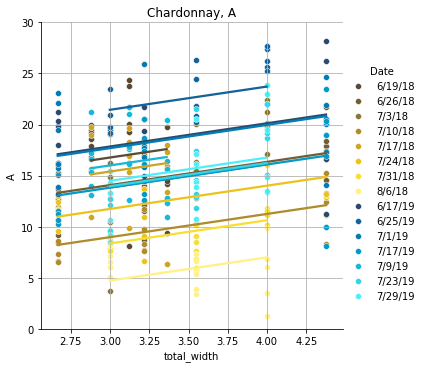

In [32]:
date_pal = {"6/19/18":"#584b36", # palette for coloring by dates
            "6/26/18":"#725e34",
            "7/3/18":"#8c7631",
            "7/10/18":"#ae8b2b",
            "7/17/18":"#cfa423",
            "7/24/18":"#ecc31c",
            "7/31/18":"#f9de2f",
            "8/6/18":"#fff184",
            "6/17/19":"#2b496d",
            "6/25/19":"#14629a",
            "7/1/19":"#017cb5",
            "7/17/19":"#039ac7",
            "7/9/19":"#17b7d7",
            "7/23/19":"#33d3e9",
            "7/29/19":"#4cf0f8"} 

plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=chard_phys, x="total_width", y="A", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Chardonnay, A")
plt.grid()
plt.ylim(0,30)
plt.savefig("FIGURE5_CHARD_A.jpg")

## Cabernet Sauvignon, A, Assimilation rate, µmol m-2 s-1

In [33]:
## Cabernet Sauvignon, A
### Assimilation rate, µmol m-2 s-1
### r = 0.276448
### p = 0.000015

pg.rm_corr(data=cab_phys, x="total_width", y="A", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.276448,236,0.000015,"[0.15, 0.39]",0.991791


<Figure size 720x720 with 0 Axes>

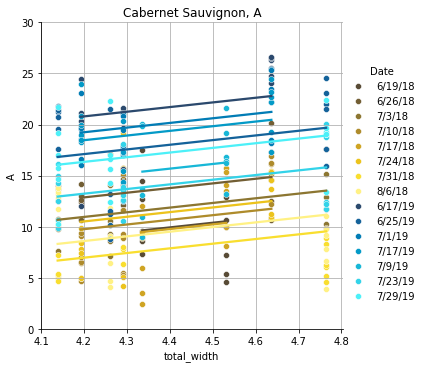

In [34]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=cab_phys, x="total_width", y="A", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Cabernet Sauvignon, A")
plt.grid()
plt.ylim(0,30)
plt.savefig("FIGURE5_CAB_A.jpg")

## Chardonnay, E, Transpiration rate, mol m-2 s-1

In [35]:
## Chardonnay, E
### Transpiration rate, mol m-2 s-1
### r = 0.334802
### p = 4.022519e-08

pg.rm_corr(data=chard_phys, x="total_width", y="E", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.334802,254,4.022519e-08,"[0.22, 0.44]",0.999834


<Figure size 720x720 with 0 Axes>

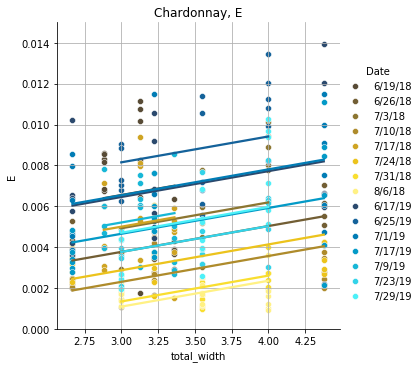

In [36]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=chard_phys, x="total_width", y="E", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Chardonnay, E")
plt.grid()
plt.ylim(0,0.015)
plt.savefig("FIGURE5_CHARD_E.jpg")

## Cabernet Sauvignon, E, Transpiration rate, mol m-2 s-1

In [37]:
## Cabernet Sauvignon, E
### Transpiration rate, mol m-2 s-1
### r = 0.339869
### p = 7.593093e-08

pg.rm_corr(data=cab_phys, x="total_width", y="E", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.339869,236,7.593093e-08,"[0.22, 0.45]",0.999746


<Figure size 720x720 with 0 Axes>

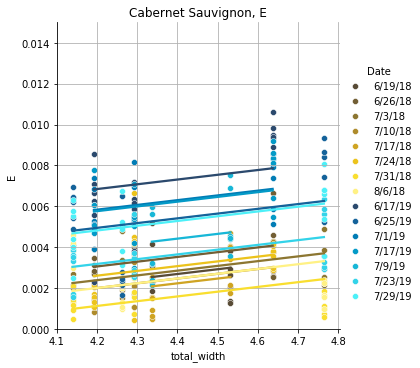

In [38]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=cab_phys, x="total_width", y="E", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Cabernet Sauvignon, E")
plt.grid()
plt.ylim(0,0.015)
plt.savefig("FIGURE5_CAB_E.jpg")

## Chardonnay, gsw, Stomatal conductance to water vapor , mol m-2 s-1

In [39]:
## Chardonnay, gsw
### Stomatal conductance to water vapor , mol m-2 s-1
### r = 0.338932
### p = 2.669052e-08

pg.rm_corr(data=chard_phys, x="total_width", y="gsw", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.338932,254,2.669052e-08,"[0.23, 0.44]",0.999875


<Figure size 720x720 with 0 Axes>

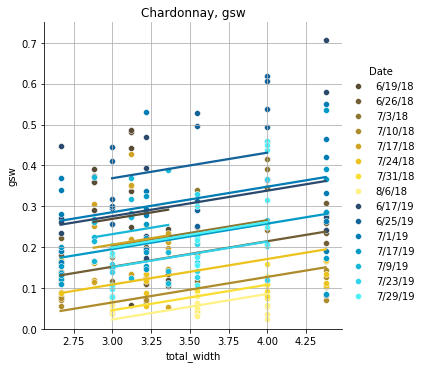

In [40]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=chard_phys, x="total_width", y="gsw", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Chardonnay, gsw")
plt.grid()
plt.ylim(0,0.75)
plt.savefig("FIGURE5_CHARD_GSW.jpg")

## Cabernet sauvignon, gsw, Stomatal conductance to water vapor , mol m-2 s-1

In [41]:
## Cabernet sauvignon, gsw
### Stomatal conductance to water vapor , mol m-2 s-1
### r = 0.366868
### p = 5.389446e-09

pg.rm_corr(data=cab_phys, x="total_width", y="gsw", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,0.366868,236,5.389446e-09,"[0.25, 0.47]",0.999961


<Figure size 720x720 with 0 Axes>

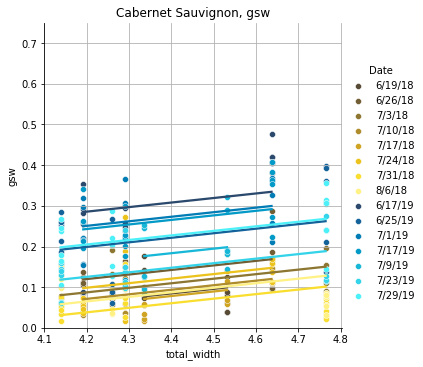

In [42]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=cab_phys, x="total_width", y="gsw", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Cabernet Sauvignon, gsw")
plt.grid()
plt.ylim(0,0.75)
plt.savefig("FIGURE5_CAB_GSW.jpg")

## Chardonnay, Leaf temperature (F)

In [43]:
## Chardonnay, Leaf temperature (F)
### r = -0.055255
### p = 0.378626

pg.rm_corr(data=chard_phys, x="total_width", y="leaf_temp", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,-0.055255,254,0.378626,"[-0.18, 0.07]",0.142537


<Figure size 720x720 with 0 Axes>

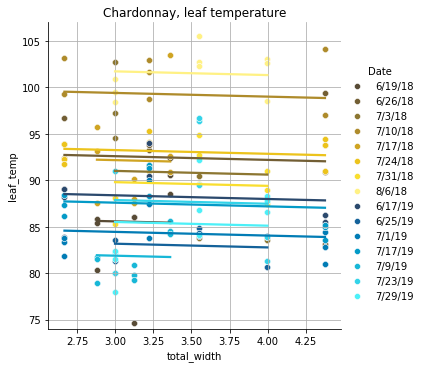

In [44]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=chard_phys, x="total_width", y="leaf_temp", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Chardonnay, leaf temperature")
plt.grid()
plt.ylim(74,107)
plt.savefig("FIGURE5_CHARD_LEAFTEMP.jpg")

## Cabernet sauvignon, Leaf temperature (F)

In [45]:
## Cabernet sauvignon, Leaf temperature (F)
### r = -0.001083
### p = 0.986745

pg.rm_corr(data=cab_phys, x="total_width", y="leaf_temp", subject="Date")

,r,dof,pval,CI95%,power
rm_corr,-0.001083,236,0.986745,"[-0.13, 0.13]",0.049964


<Figure size 720x720 with 0 Axes>

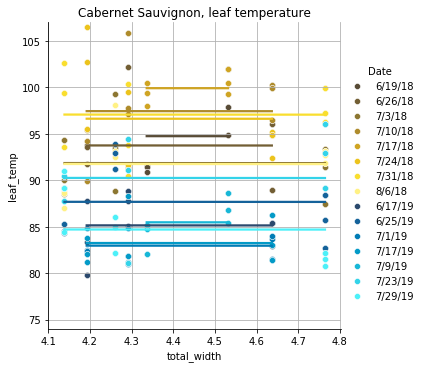

In [46]:
plt.figure(figsize=(10,10))
pg.plot_rm_corr(data=cab_phys, x="total_width", y="leaf_temp", subject="Date", legend=True, 
                kwargs_facetgrid=dict(palette=date_pal, height=5))
plt.title("Cabernet Sauvignon, leaf temperature")
plt.grid()
plt.ylim(74,107)
plt.savefig("FIGURE5_CAB_LEAFTEMP.jpg")